## Issuance of a PRC as QR code

In [65]:
# Load the private key from the PEM file
with open('private_key_ec.pem', 'rb') as f:
    private_key_pem = f.read()

In [66]:
# Compute fingerprint of private key
from helper import get_ec_private_key_fingerprint
fingerprint = get_ec_private_key_fingerprint(private_key_pem)
print("Hex-encoded fingerprint:", fingerprint)

Hex-encoded fingerprint: 3e47b334052d2575f1943c8af41026580810f88c30a236db0ef19bdd8a5d92a2


### EHIC data sample

In [79]:
sample_ehic_data = {
    "ic": "BE",
    "hn": {
        "fn": "Clément-Lafarge",
        "gn": "Jean-Pierre, Frédéric",
    },
    "dob": "29-02-2000",
    "hi": "0001019999",
    "ii": "0216X",
    "in": "LAMUTUALITENEUTRE",
    "ci": "021XXXXXXX2023035407",
    "sd": "28-02-2023",
    "ed": "29-02-2024",
    "id": "31-01-2024"
}
print("Approx. byte size:", len(str(sample_ehic_data)))

Approx. byte size: 249


"{'ic': 'BE', 'hn': {'fn': 'Clément-Lafarge', 'gn': 'Jean-Pierre, Frédéric'}, 'dob': '29-02-2000', 'hi': '0001019999', 'ii': '0216X', 'in': 'LAMUTUALITENEUTRE', 'ci': '021XXXXXXX2023035407', 'sd': '28-02-2023', 'ed': '29-02-2024', 'id': '31-01-2024'}"

### Create payload of verifiable credential
The credentialSubject is the actual EHIC data sample

In [78]:
verifiable_credential = {
    "@context": [
        "https://www.w3.org/2018/credentials/v1",
        "https://w3id.org/vc/status-list/2021/v1"
    ],
    "type": [
        "VerifiableCredential",
        "EHICCredential"
    ],
    "credentialSubject": sample_ehic_data,
    "credentialSchema": {
        "id": "https://api-pilot.ebsi.eu/trusted-schemas-registry/v3/schemas/0xfa899fd2bc2a5a66ad51f9881813401ebe02f7dd40b0926c3e49c9514a77cb6a",
        "type": "FullJsonSchemaValidator2021"
    }
}
print("Approx. byte size:", len(str(verifiable_credential)))

Approx. byte size: 622


### Build JSON web token

In [80]:
import jwt
import datetime
import json

# Define the content of the JWT
payload = {
    "iat": int(datetime.datetime.now().timestamp()),  # Issued at
    "nbf": int(datetime.datetime.now().timestamp()),  # Not before
    "exp": int((datetime.datetime.now() + datetime.timedelta(days=365)).timestamp()), # Expiration date
    "vc": verifiable_credential,
    "iss": f"ESSI:BE:0100:{fingerprint}", # Issuer
}

print(json.dumps(payload, indent=4))
print("Approx. byte size:", len(str(payload)))

{
    "iat": 1741195424,
    "nbf": 1741195424,
    "exp": 1772731424,
    "vc": {
        "@context": [
            "https://www.w3.org/2018/credentials/v1",
            "https://w3id.org/vc/status-list/2021/v1"
        ],
        "type": [
            "VerifiableCredential",
            "EHICCredential"
        ],
        "credentialSubject": {
            "ic": "BE",
            "hn": {
                "fn": "Cl\u00e9ment-Lafarge",
                "gn": "Jean-Pierre, Fr\u00e9d\u00e9ric"
            },
            "dob": "29-02-2000",
            "hi": "0001019999",
            "ii": "0216X",
            "in": "LAMUTUALITENEUTRE",
            "ci": "021XXXXXXX2023035407",
            "sd": "28-02-2023",
            "ed": "29-02-2024",
            "id": "31-01-2024"
        },
        "credentialSchema": {
            "id": "https://api-pilot.ebsi.eu/trusted-schemas-registry/v3/schemas/0xfa899fd2bc2a5a66ad51f9881813401ebe02f7dd40b0926c3e49c9514a77cb6a",
            "type": "FullJsonSc

### Sign JWT

In [81]:
encoded_jws = jwt.encode(payload, private_key_pem, algorithm='ES256')
print("Encoded JWS (JWT):", encoded_jws)
print("Approx. byte size:", len(encoded_jws))

Encoded JWS (JWT): eyJhbGciOiJFUzI1NiIsInR5cCI6IkpXVCJ9.eyJpYXQiOjE3NDExOTU0MjQsIm5iZiI6MTc0MTE5NTQyNCwiZXhwIjoxNzcyNzMxNDI0LCJ2YyI6eyJAY29udGV4dCI6WyJodHRwczovL3d3dy53My5vcmcvMjAxOC9jcmVkZW50aWFscy92MSIsImh0dHBzOi8vdzNpZC5vcmcvdmMvc3RhdHVzLWxpc3QvMjAyMS92MSJdLCJ0eXBlIjpbIlZlcmlmaWFibGVDcmVkZW50aWFsIiwiRUhJQ0NyZWRlbnRpYWwiXSwiY3JlZGVudGlhbFN1YmplY3QiOnsiaWMiOiJCRSIsImhuIjp7ImZuIjoiQ2xcdTAwZTltZW50LUxhZmFyZ2UiLCJnbiI6IkplYW4tUGllcnJlLCBGclx1MDBlOWRcdTAwZTlyaWMifSwiZG9iIjoiMjktMDItMjAwMCIsImhpIjoiMDAwMTAxOTk5OSIsImlpIjoiMDIxNlgiLCJpbiI6IkxBTVVUVUFMSVRFTkVVVFJFIiwiY2kiOiIwMjFYWFhYWFhYMjAyMzAzNTQwNyIsInNkIjoiMjgtMDItMjAyMyIsImVkIjoiMjktMDItMjAyNCIsImlkIjoiMzEtMDEtMjAyNCJ9LCJjcmVkZW50aWFsU2NoZW1hIjp7ImlkIjoiaHR0cHM6Ly9hcGktcGlsb3QuZWJzaS5ldS90cnVzdGVkLXNjaGVtYXMtcmVnaXN0cnkvdjMvc2NoZW1hcy8weGZhODk5ZmQyYmMyYTVhNjZhZDUxZjk4ODE4MTM0MDFlYmUwMmY3ZGQ0MGIwOTI2YzNlNDljOTUxNGE3N2NiNmEiLCJ0eXBlIjoiRnVsbEpzb25TY2hlbWFWYWxpZGF0b3IyMDIxIn19LCJpc3MiOiJFU1NJOkJFOjAxMDA6M2U0N2IzMzQwNTJkMjU3NWYxOTQzYzhhZjQx

### Generate QR code

Compress encoded JWS using ZLib

In [82]:
import zlib
import base64

# Compress the JWS using zlib
compressed_jws = zlib.compress(encoded_jws.encode('utf-8'))

compressed_jws_b64 = base64.b64encode(compressed_jws).decode('utf-8')
print("Compressed JWS (base64):", compressed_jws_b64)
print("Approx. byte size:", len(compressed_jws))

Compressed JWS (base64): eJxdU9GSojoU/KMtBHGXxxEEgyYsGILJy5YERwJBuSMjJF+/QWdr770PFuWB092nT5+ziusy4iIRcZhrsEAC3ME1c7kPVqDtj8SPvW9nFff0mIqk2Tgo2EwJzi3YpHfQuYIJsIKYWxBvXIRThfxRsGM9guY2Ic0V0nBCAbD2fmxTBVYG643a3mcVkWVlSAoV36ptNnJ9e+ydyqmU60DlPnjHH7B5mxLfa3hHWla41qkI71x5NjwYkV1tVdu1TsSPR6VRz/xXT9XBB3eyutoSvS+mnjvpjKPgYe6LK6PDOh/XEjR9CSSTvJOdwRVlRIJ/8wAxiiyv49RCihWZLK9ZT4tRHA+joE4sWUTMDLIuQ7SgXS+pY/y53sWpgLOZfvbS+Gl4voOOmedNpPbEK/w2MiyHmWefTzXrQsXsXBhd11I8TZe0WA55JCW/xnLvryMupwUM1jIpsj/9auZ5N1pY5IkZGzbtAAMwmFlH6D+5+2c9MP+x8RG3bvLUJL/qYELyMvP2L95pjQnJSR7CA8lC3BJCwjicfaB2a2YCI2xCWoT18/f0VL9ps/MRqTk0qH3puPzRoeBcN57+T5/JyFPHq643pr75qsee0fOffec2urFiUb98fPWctpnFt3C1V17No3bgkbyXTvrJilifDq6sDp7Fr0SbjLX7I2pOERnoEQ4G93o6IvOufVSNyckXNlc/xnPE6iRoXdalinZQUUxq1LCaBfnEmnaZBJslxNCCQShpl4+wow6LUgtGYEwwsKlGEgWyMbcxocjciY0E6jbib95uIruSe7npdWm7mNq1LIuwoCajLAqt0gFq3gm4LmYPTG7h6ygXKE7aOEzMLZhdrqCdW8gGGmrjO45b2OQOKqjZb6qprmvWpOY7YCN8GY3mkTWXJdVwpBho1GUCRqSDWJrcpEszY5vguIbCHHm5w+EoH0itqmHZ+z+3Vr0obmPTPFZuNPTv1uT5Vub

Encode the compressed data using Base45

In [83]:
import base45

base45_encoded = base45.b45encode(compressed_jws)
print("Base45 encoded JWS:", base45_encoded)
print("Approx. byte size:", len(base45_encoded))

Base45 encoded JWS: b'6BF-ZBAMQ+MKHT2DSKCP0K8J 624QG%P51OG8XPFO0$C0AIN-J4V4C3C81TDO+NB+2PIG/0S/2AHVM0XTKQSA924CJUCMCG06JOFSEB.1MFK*7IW7IY3E/Y2L-UWNHXKRG75PR9-2QKHRR6FFKN5A1.MG2NBN3EZWGA.GWEAPOCUOG.$6V-P7RQMF8WGM9:FDMAH*A1ZT5URJ1D6HI8 CGC1ICSD DELE:TFT.JWJLEXT6:S4CFC04 GFGH2HQD-09F/A86R$513VBO%6Y43M BJ%AJ-M9%OQ29IFAO+V74A5IO.5F:RNRG231670KSNTCWK5HCWQHSVKTF7N8RRS6071KUIYTIJIO4 CHMGIWU$B69T54 SOI8*W29T53DBPRHSO3%UKW*9$CB ZPTNM7P8DCK616 SCHMNL:O7CG9IJ69V8IV+BFISGOKJV 9$8VAP5E%6ES5VHJD6KX 6%J8S*TR33.9R2S718J.5B7EFXY4.3PODU6K475L1S1GF61OMT1W66T+:6VAB.EH J3C/T6I0VBJ349N289ZV4X7REWILUN8NJVU2T4FST%K8%J6N5VC5SF$H4KP:*3OL0GK8*D2+OOBZJ%CK:PD7C0*UD.JB84VQFV5WAEGDZWUVHLPT6D-FGHNPMQGGSI17X6W09KSEP+AP41MQ3LEPVRAPHOQE7KFAT3RNEJCF9O*ZFN JZJJP8NS-ME:B-TKOHS*$ND:9OLP79BN%1 XLA3K37M+TJC0NLL45*9HC3172S*0FKF$I4T2M0VA.MP2.2F1B/3PA+O5R4$%BX-K3/EMCAXMDUEM:X0K%OV:E9Q0%Y48GQUA8VFDJ7IRRKQRH6J1$7C:66:HLNC2WNM77NGKKR*RA$HIRT7SSH5SQH4ENISMN.$E9WN9TRIS5 EM *4OP5%/L28063SZCNR+C T9APS335D45JQR+V9HY5.$BWDK6RBWY03ND N7MRB

Generate QR code

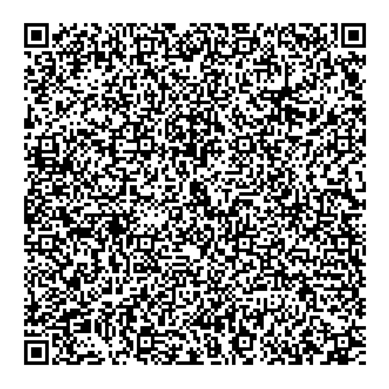

In [73]:
import qrcode
import matplotlib.pyplot as plt

# Create a QR code instance
qr = qrcode.QRCode(
    version=1,  # Controls the size of the QR Code
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)

qr.add_data(base45_encoded)
qr.make(fit=True)

# Create an image from the QR code instance
img = qr.make_image(fill='black', back_color='white')
img.save("qrcode.png")


# Display the image in the notebook
plt.imshow(img, cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()